# Anime Recommendation System
- **Sumber Data:** https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database

##  Load Data

In [1]:
#mengimpor library yang diperlukan
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import operator

In [2]:
# Clone dataset dari github
!git clone https://github.com/lusiaulia/anime-recommendation.git
# mendefinisikan dataframe
anime_df = pd.read_csv("/content/anime-recommendation/anime.csv")
rate_df = pd.read_csv("/content/anime-recommendation/rating.csv")
anime_df.head()

Cloning into 'anime-recommendation'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 4), reused 15 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 25.33 MiB | 11.30 MiB/s, done.
Resolving deltas: 100% (4/4), done.


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
rate_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Exploratory Data Analysis

Variabel-variabel dari anime dan rating dataset adalah sebagai berikut :

1. Variabel anime.csv yang selanjutnya disebut anime_df
<ul> <li>anime_id : id anime dari myanimelist.</li>
    <li>name : judul anime</li>
    <li>genre : genre anime</li>
    <li>type : movie, TV, OVA, dll.</li>
    <li>episodes : banyak episode (1 jika movie).</li>
    <li>rating : rata-rata rating dari anime (skala 1-10)</li>
    <li>members : jumlah member dalam grup anime</li>
</ul>

2. Variabel rating.csv yang selanjutnya disebut rate_df
<ul> <li>user_id : id user</li>
    <li>anime_id : anime yang dinilai/rate oleh user</li>
    <li>rating : rating skala 1-10 yang diberi oleh user (rating -1 jika sudah menonton tapi belum memberi rating)</li>
</ul>

In [4]:
#melihat informasi jumlah dan jenis data
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [5]:
rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Berdasarkan output di atas, dapat diketahui bahwa rate_df memiliki 7813737 data entri, sementara anime_df memiliki 12294 entri.

In [6]:
#melihat statistik deskriptif dari data
anime_df.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [7]:
rate_df.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [8]:
print('Jumlah animeID: ', len(anime_df.anime_id.unique()))
print('Jumlah animeID: ', len(rate_df.anime_id.unique()))

Jumlah animeID:  12294
Jumlah animeID:  11200


Dari data, diketahui bahwa rating berada di rentang 1-10, jumlah list anime ID pada anime_df ada 12294 list dan pada rate_df terdapat 11200 list anime ID. Selanjutnya akan dicari tahu apakah terdapat data kosong, duplikat pada dataset. Juga upaya untuk lebih merapihkan data sebelum dimodelkan.

## Data Preprocessing & Data Prep

Sudah disebutkan sebelumnya bahwa salah satu variabel pada rate_df yaitu rating terdapat 1 nilai yaitu '-1' yang berati user belum memberi penilaian dan sudah menonton. Agar tidak mempengaruhi hasil prediksi rating maka akan dihapus saja.

In [9]:
rate_df = rate_df[rate_df['rating'] != -1]
rate_df

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [10]:
print('Jumlah animeID: ', len(rate_df.anime_id.unique()))

Jumlah animeID:  9927


In [11]:
len(rate_df)

6337241

Saat ini dengan rate_df sejumlah 6337241 dan anime pada rate_df sejumlah 9927 anime yang berbeda (anime_id)

### Mengatasi null value

In [12]:
#mengecek apakah ada data kosong
for column, i in anime_df.isnull().sum().items():
    if i > 0:
        print(f"{column}: {i/len(anime_df)*100:.2f}%")

genre: 0.50%
type: 0.20%
rating: 1.87%


In [13]:
#mengecek apakah ada data kosong
for column, i in rate_df.isnull().sum().items():
    if i > 0:
        print(f"{column}: {i/len(rate_df)*100:.2f}%")

Terdapat sejumlah kurang dari 2% data kosong dari anime_df, sehingga akan dilakukan penghapusan data kosong.Sementara pada rate_df tidak terdapat data kosong.

In [14]:
anime_df = anime_df.dropna(axis=0).reset_index(drop=True)
anime_df.isnull().sum()

,0
anime_id,0
name,0
genre,0
type,0
episodes,0
rating,0
members,0


In [15]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12017 entries, 0 to 12016
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 657.3+ KB


Setelah dilakukan penghapusan data kosong, saat ini terdapat sejumlah 12017 data entri pada anime_df. Selanjutnya mari dicek untuk data duplikat.

### Mengatasi data duplikat

In [16]:
print(anime_df[anime_df.duplicated()].shape[0])
print(rate_df[rate_df.duplicated()].shape[0])

0
1


Tidak terdapat duplikat data pada data anime_df dan ada 1 data duplikat pada rate_df, akan dilakukan penghapusan data yang terduplikasi.

In [17]:
rate_df.drop_duplicates(keep='first',inplace=True)
print(rate_df[rate_df.duplicated()].shape[0])

0


terlihat sudah tidak terdapat data duplikat. Kemudian dilakukan penghapusan duplikat juga pada pengguna dengan anime yang sama (asumsi 1 pengguna memberi 1 rating pada 1 anime yang ditonton)

In [18]:
rate_df = rate_df.drop_duplicates(['user_id', 'anime_id'])
len(rate_df)

6337234

Yang sebelumnya berjumlah 6337241 saat ini menjadi 6337234 data pada rate_df

### Visualisasi Data

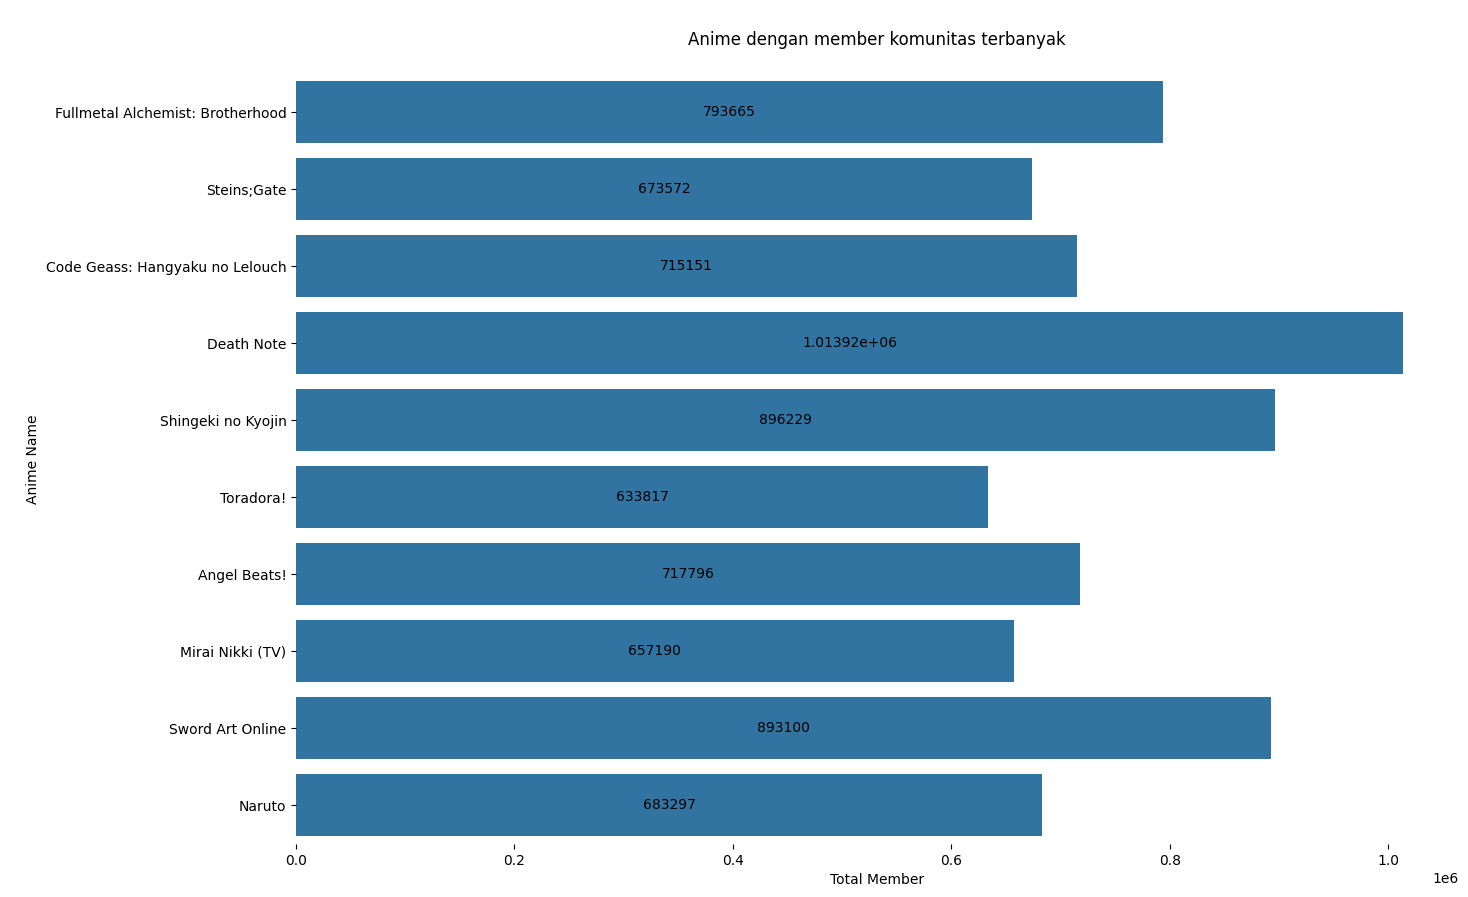

In [19]:
most_an = anime_df.sort_values(["members"],ascending=False)

plt.subplots(figsize=(15,10))
p = sns.barplot(x=most_an["members"], y=most_an["name"][:10])
p.axes.set_title("\nAnime dengan member komunitas terbanyak\n")
plt.xlabel("Total Member")
plt.ylabel("\nAnime Name")
for container in p.containers:
    p.bar_label(container,label_type = "center", color = "black")

sns.despine(left=True, bottom=True)
plt.show()

Terlihat jumlah dari member komunitas tiap anime berbeda-beda. Kemudian coba kita lihat jenis data pada kolom type pada anime_df

In [20]:
anime_df['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA'], dtype=object)

Ternyata tipe anime terbanyak yaitu yang muncul di televisi (TV),OVA, Movie, Spesial, ONA, dan Music. Secara visual terlihat di bawah ini

In [21]:
type_a = anime_df.sort_values(["type"],ascending=False)
def pie_chart(df, col, title):
    labels = [i for i in df[col].value_counts().index]
    df[col].value_counts().plot.pie(figsize=(8,8),
                                                 pctdistance=0.4,
                                                 startangle=90,
                                                 textprops={"color": "white"},
                                                 wedgeprops={"linewidth":0})
#                                    colors=['sandybrown','chocolate','brown','saddlebrown','black'])
    plt.title(title, fontsize=20, pad=5)
    box = plt.gca().get_position()
    plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), prop={"size":12,
                                                                 "weight":"ultralight"})
    plt.show();

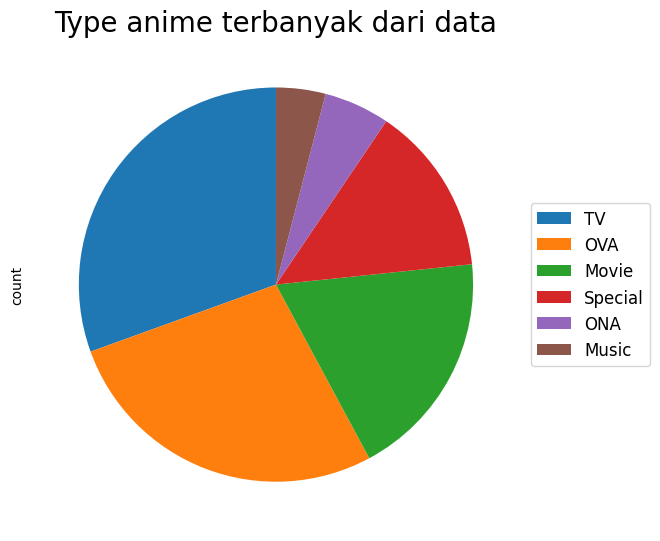

In [22]:
pie_chart(type_a, "type", "Type anime terbanyak dari data")

In [23]:
type_an = ['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA']
counts={}
for i in type_an:
    counts[i] = (((anime_df['type'] == i).sum())/len(anime_df.type)*100)

print(counts)

{'Movie': 18.798368977282184, 'TV': 30.523425147707417, 'OVA': 27.327952067903805, 'Special': 13.896979279354248, 'Music': 4.060913705583756, 'ONA': 5.392360822168595}


Jumlah terbanyak yaitu anime yang tayang di TV (biasanya berepisode), disusul dengan OVA, Movie, Spesial, ONA dan Music.

<Axes: >

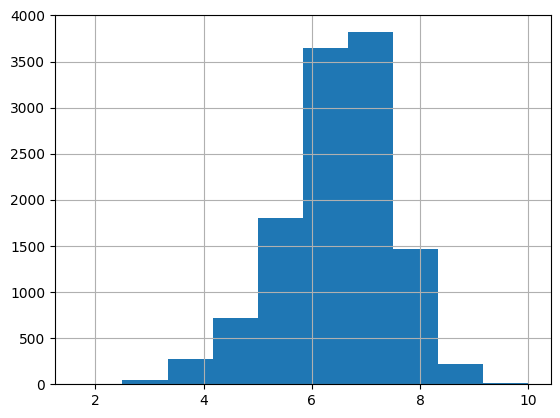

In [24]:
anime_df.rating.hist()

Dari histogram terlihat bahwa sebaran rating berada di rentang 2-9 dan paling banyak di kisaran rating 7

## Modeling & Evaluate Model
### User-Based Collaborative Filtering¶
#### TF-IDF Vectorizer


In [25]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()
tfidf_matrix = tf.fit_transform(anime_df['name'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(12017, 11952)

Perhatikanlah, matriks yang kita miliki berukuran (12017, 11951).

Untuk menghasilkan vektor tf-idf dalam bentuk matriks, kita menggunakan fungsi todense(). Jalankan kode berikut.

In [26]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
# Membuat dataframe untuk melihat tf-idf matrix
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=anime_df.name
).sample(11952, axis=1).sample(10, axis=0)

,yami,luffy,uragiri,guns,previsited,yokatta,superboard,duo,zestiria,sat,...,kakarichou,to,pyun,nenga,ina,kamotori,yatsu,nandemo,vicious,cheonbangjichuk
name,,,,,,,,,,,,,,,,,,,,,
Seishain Cyborg 003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ginga Tetsudou 999: Glass no Clair,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Umacha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sore Ike! Anpanman: Ruby no Negai,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Peut-etre Toi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tabi Machi Late Show,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gdgd Fairies 2 Episode 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gangsta. Recap,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Umi kara no Shisha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cosine Similarity

In [28]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.034281  , 0.02800732,
        0.03361191],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.034281  , 0.        , 0.        , ..., 1.        , 0.81699263,
        0.02039521],
       [0.02800732, 0.        , 0.        , ..., 0.81699263, 1.        ,
        0.01666274],
       [0.03361191, 0.        , 0.        , ..., 0.02039521, 0.01666274,
        1.        ]])

In [29]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa id anime
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime_df['name'], columns=anime_df['name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (12017, 12017)


name,Kanokon: Manatsu no Dai Shanikusai,Kujiratori,Bungou Stray Dogs,Marine Dreamin&#039;,Love Hina Again
name,,,,,
Mashou no Kao,0.027473,0.0,0.0,0.0,0.0
Ai Shimai: Futari no Kajitsu,0.023121,0.0,0.0,0.0,0.0
Mainichi ga Nichiyoubi,0.000000,0.0,0.0,0.0,0.0
Jakusansei Million Arthur Specials,0.000000,0.0,0.0,0.0,0.0
InuYasha: Kuroi Tessaiga,0.000000,0.0,0.0,0.0,0.0
Uta Kata,0.000000,0.0,0.0,0.0,0.0
A.LI.CE,0.000000,0.0,0.0,0.0,0.0
Mori no Densetsu,0.037267,0.0,0.0,0.0,0.0
Uchi no 3 Shimai,0.029252,0.0,0.0,0.0,0.0


### Mendapat Rekomendasi

In [30]:
def anime_recommendations(name, similarity_data=cosine_sim_df, items=anime_df[['name', 'anime_id','genre']], k=5):
    index = similarity_data.loc[:,name].to_numpy().argpartition(
        range(-1, -k, -1))

    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(name, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [31]:
anime_df[anime_df.name.eq('Shingeki no Kyojin')]

,anime_id,name,genre,type,episodes,rating,members
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229


In [32]:
# Mendapatkan rekomendasi anime yang mirip dengan Shingeki no Kyojin
anime_recommendations('Shingeki no Kyojin')

,name,anime_id,genre
0,Shingeki no Kyojin OVA,18397,"Action, Drama, Fantasy, Shounen, Super Power"
1,Shingeki no Kyojin Picture Drama,19391,"Comedy, Parody"
2,Shingeki! Kyojin Chuugakkou,31374,"Comedy, Parody, School, Shounen"
3,Shingeki no Kyojin: Ano Hi Kara,19285,"Action, Drama, Fantasy, Shounen, Super Power"
4,Shingeki no Kyojin: Kuinaki Sentaku,25781,"Action, Fantasy, Shoujo, Supernatural"


### Model RecommederNet

In [33]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_anime, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_anime = num_anime
        self.embedding_size = embedding_size

        # Layer embedding untuk pengguna
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        # Layer embedding untuk anime
        self.anime_embedding = layers.Embedding(
            num_anime,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.anime_bias = layers.Embedding(num_anime, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 1])
        anime_bias = self.anime_bias(inputs[:, 1])

        # Hitung dot product antara user dan anime embedding
        dot_user_anime = tf.tensordot(user_vector, anime_vector, axes=2)

        # Tambahkan bias
        x = dot_user_anime + user_bias + anime_bias
        return tf.nn.sigmoid(x)

In [34]:
# Normalisasi user_id dan anime_id ke dalam range embedding
from sklearn.preprocessing import LabelEncoder

# Encode user_id
user_encoder = LabelEncoder()
rate_df['user_id'] = user_encoder.fit_transform(rate_df['user_id'])

# Encode anime_id
anime_encoder = LabelEncoder()
rate_df['anime_id'] = anime_encoder.fit_transform(rate_df['anime_id'])

num_users = rate_df['user_id'].nunique()
num_anime = rate_df['anime_id'].nunique()

model = RecommenderNet(num_users,num_anime, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

<ipython-input-34-9248806342af>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_df['user_id'] = user_encoder.fit_transform(rate_df['user_id'])
<ipython-input-34-9248806342af>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_df['anime_id'] = anime_encoder.fit_transform(rate_df['anime_id'])


In [35]:
# Data Preparation
x = rate_df[['user_id', 'anime_id']].values
y = rate_df['rating'].values

# Normalisasi rating ke skala 0-1
y = (y - y.min()) / (y.max() - y.min())

# Split data menjadi train dan test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [36]:
# Train Model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=10,
    validation_data=(x_test, y_test)
)

Epoch 1/10
39608/39608 ━━━━━━━━━━━━━━━━━━━━ 114s 3ms/step - loss: 0.5843 - root_mean_squared_error: 0.1931 - val_loss: 0.7069 - val_root_mean_squared_error: 0.2494
Epoch 2/10
39608/39608 ━━━━━━━━━━━━━━━━━━━━ 138s 3ms/step - loss: 0.7639 - root_mean_squared_error: 0.2709 - val_loss: 0.8641 - val_root_mean_squared_error: 0.2939
Epoch 3/10
39608/39608 ━━━━━━━━━━━━━━━━━━━━ 106s 3ms/step - loss: 0.9400 - root_mean_squared_error: 0.3137 - val_loss: 1.0099 - val_root_mean_squared_error: 0.3106
Epoch 4/10
39608/39608 ━━━━━━━━━━━━━━━━━━━━ 99s 2ms/step - loss: 1.0971 - root_mean_squared_error: 0.3409 - val_loss: 1.1365 - val_root_mean_squared_error: 0.3190
Epoch 5/10
39608/39608 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 1.2240 - root_mean_squared_error: 0.3587 - val_loss: 1.2261 - val_root_mean_squared_error: 0.3175
Epoch 6/10
39608/39608 ━━━━━━━━━━━━━━━━━━━━ 107s 3ms/step - loss: 1.3175 - root_mean_squared_error: 0.3648 - val_loss: 1.3215 - val_root_mean_squared_error: 0.3185
Epoch 7/10
39608/

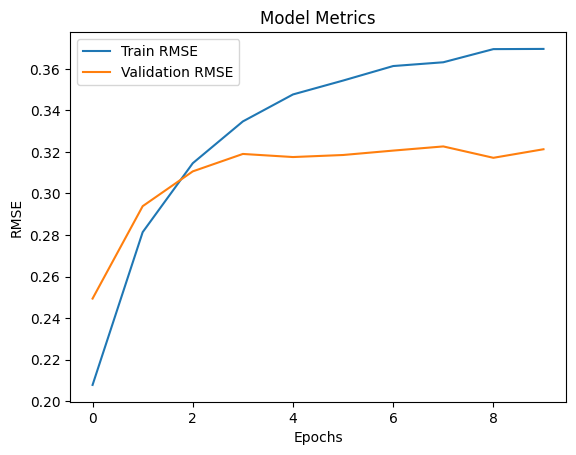

In [37]:
# Visualisasi Hasil Training
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Model Metrics')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [38]:
# Rekomendasi Anime
def recommend_anime(user_id, top_n=5):
    anime_watched_by_user = rate_df[rate_df.user_id == user_id]
    anime_not_watched = anime_df[~anime_df['anime_id'].isin(anime_watched_by_user['anime_id'])]
    anime_not_watched['user_id'] = user_id
    user_anime_array = anime_not_watched[['user_id', 'anime_id']].values

    # Prediksi rating untuk anime yang belum ditonton
    predictions = model.predict(user_anime_array)
    anime_not_watched['predicted_rating'] = predictions

    # Urutkan berdasarkan prediksi tertinggi
    recommendations = anime_not_watched.sort_values('predicted_rating', ascending=False).head(top_n)
    return recommendations[['name', 'genre', 'predicted_rating']]

user_id = 2  # Ganti dengan user_id lain
recommendations = recommend_anime(user_id)
print(recommendations)


<ipython-input-38-c7ca4a6e23b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_not_watched['user_id'] = user_id


374/374 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                                                   name  \
1796                                     Rekka no Honoo   
1783                   El Hazard: The Magnificent World   
1776                               Zoids Shinseiki/Zero   
1798                 Soukou Kihei Votoms: Pailsen Files   
2514  Dragon Ball Z Movie 05: Tobikkiri no Saikyou t...   

                                                  genre  predicted_rating  
1796  Action, Adventure, Martial Arts, Shounen, Supe...          0.999989  
1783                Adventure, Comedy, Fantasy, Romance          0.999987  
1776  Adventure, Comedy, Mecha, Sci-Fi, Shounen, Sports          0.999983  
1798                     Mecha, Military, Sci-Fi, Space          0.999971  
2514        Adventure, Comedy, Fantasy, Sci-Fi, Shounen          0.999967  


<ipython-input-38-c7ca4a6e23b4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_not_watched['predicted_rating'] = predictions
